In [1]:
dir

<function dir>

In [2]:
cd .

C:\Users\nakatanikenichi\Lesson\attacks\input


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets as dt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import numpy as np
import seaborn as sns


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread, imshow

X,y = dt.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)

In [5]:
from subprocess import check_output

In [6]:
df = pd.read_csv("../input/digit-recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y = df.label.values
X = df.drop("label",axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

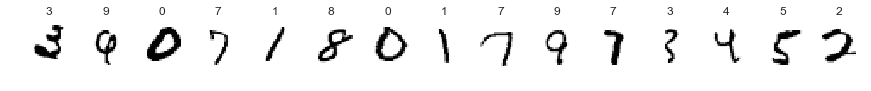

In [8]:
fig1, ax1 = plt.subplots(1,15, figsize=(15,10))
for i in range(15):
    ax1[i].imshow(X_test[i].reshape((28,28)))
    ax1[i].axis('off')
    ax1[i].set_title(y_test[i])

In [9]:
def calc_output_weighted_weights(output, w):
    for c in range(len(output)):
        if c == 0:
            weighted_weights = output[c] * w[c]
        else:
            weighted_weights += output[c] * w[c]
    return weighted_weights

def targeted_gradient(foolingtarget, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(output)):
        if k == 0:
            gradient = foolingtarget[k] * (w[k]-ww)
        else:
            gradient += foolingtarget[k] * (w[k]-ww)
    return gradient

def non_targeted_gradient(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        if k == 0:
            gradient = (1-target[k]) * (w[k]-ww)
        else:
            gradient += (1-target[k]) * (w[k]-ww)
    return gradient

def non_targeted_sign_gradient(target, output, w):
    gradient = non_targeted_gradient(target, output, w)
    return np.sign(gradient)

In [10]:
class Attack:

    def __init__(self, model):
        self.fooling_targets = None
        self.model = model
    
    def prepare(self, X_train, y_train, X_test, y_test):
        self.images = X_test
        self.true_targets = y_test
        self.num_samples = X_test.shape[0]
        self.train(X_train, y_train)
        print("Model training finished.")
        self.test(X_test, y_test)
        print("Model testing finished. Initial accuracy score: " + str(self.initial_score))
    
    def set_fooling_targets(self, fooling_targets):
        self.fooling_targets = fooling_targets
        
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.weights = self.model.coef_
        self.num_classes = self.weights.shape[0]

    def test(self, X_test, y_test):
        self.preds = self.model.predict(X_test)
        self.preds_proba = self.model.predict_proba(X_test)
        self.initial_score = accuracy_score(y_test, self.preds)
    
    def create_one_hot_targets(self, targets):
        self.one_hot_targets = np.zeros(self.preds_proba.shape)
        for n in range(targets.shape[0]):
            self.one_hot_targets[n, targets[n]] = 1
            
    def attack(self, attackmethod, epsilon):
        perturbed_images, highest_epsilon = self.perturb_images(epsilon, attackmethod)
        perturbed_preds = self.model.predict(perturbed_images)
        score = accuracy_score(self.true_targets, perturbed_preds)
        return perturbed_images, perturbed_preds, score, highest_epsilon

    def perturb_images(self, epsilon, gradient_method):
        perturbed = np.zeros(self.images.shape)
        max_perturbations = []
        for n in range(self.images.shape[0]):
            perturbation = self.get_perturbation(epsilon, gradient_method, self.one_hot_targets[n], self.preds_proba[n])
            perturbed[n] = self.images[n] + perturbation
            max_perturbations.append(np.max(perturbation))
        highest_epsilon = np.max(np.array(max_perturbations))
        return perturbed, highest_epsilon
    
    def get_perturbation(self, epsilon, gradient_method, target, pred_proba):
        gradient = gradient_method(target, pred_proba, self.weights)
        inf_norm = np.max(gradient)
        perturbation = epsilon/inf_norm * gradient
        return perturbation
        
    def attack_to_max_epsilon(self, attackmethod, max_epsilon):
        self.max_epsilon = max_epsilon
        self.scores = []
        self.epsilons = []
        self.perturbed_images_per_epsilon = []
        self.perturbed_outputs_per_epsilon = []
        for epsilon in range(0, self.max_epsilon):
            perturbed_images, perturbed_preds, score, highest_epsilon = self.attack(attackmethod, epsilon)
            self.epsilons.append(highest_epsilon)
            self.scores.append(score)
            self.perturbed_images_per_epsilon.append(perturbed_images)
            self.perturbed_outputs_per_epsilon.append(perturbed_preds)

In [13]:
attack = Attack(model)
attack.prepare(X_train, y_train, X_test, y_test)

Model training finished.
Model testing finished. Initial accuracy score: 0.90994047619


In [12]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', fit_intercept=False)

In [14]:
weights = attack.weights
weights.shape

(10, 784)

In [15]:
num_classes = len(np.unique(y_train))
num_classes

10

In [16]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_gradient, 30)
non_targeted_scores = attack.scores

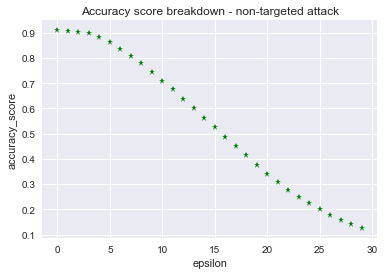

In [17]:
plt.figure()
plt.plot(attack.epsilons, attack.scores, 'g*')
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown - non-targeted attack')

In [18]:
eps = 16
attack.epsilons[eps]

16.0

In [19]:
example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]

In [20]:
example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values
example_results.head()

,y_true,y_fooled,y_predicted,id
0,3,0,2,0
1,9,4,9,1
2,0,0,0,2
3,7,3,7,3
4,1,1,1,4


In [21]:
success_df = example_results[example_results.y_fooled != example_results.y_true]
success_df.head()

,y_true,y_fooled,y_predicted,id
0,3,0,2,0
1,9,4,9,1
3,7,3,7,3
5,8,5,8,5
7,1,8,1,7


In [22]:
example_id = success_df.id.values[0]
example_id

0

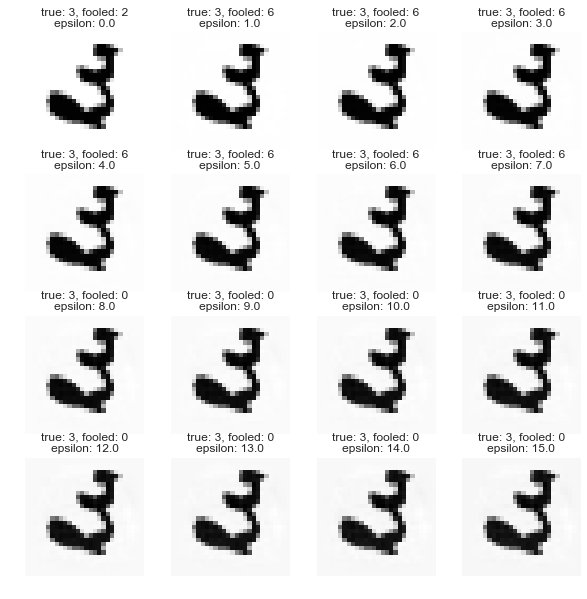

In [23]:
fig2, ax2 = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
    for j in range(4):
        image = attack.perturbed_images_per_epsilon[i*4 + j][example_id]
        y_fooled = attack.perturbed_outputs_per_epsilon[i*4 + j][example_id]
        epsilon = attack.epsilons[i*4 +j]
        ax2[i,j].imshow(image.reshape((28,28)))
        ax2[i,j].axis('off')
        ax2[i,j].set_title("true: " + str(y_test[example_id]) + ", fooled: " + str(y_fooled)  + "\n" 
                           + "epsilon: " + str(epsilon))

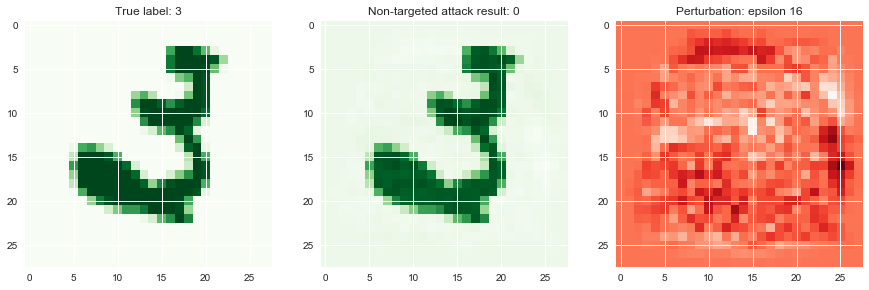

In [24]:
fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15,5))
axB.imshow(example_images[example_id].reshape((28,28)), cmap='Greens')
axB.set_title("Non-targeted attack result: " + str(example_preds[example_id]))
axA.imshow(X_test[example_id].reshape((28,28)), cmap='Greens')
axA.set_title("True label: " + str(y_test[example_id]))
axC.imshow((X_test[example_id]-example_images[example_id]).reshape((28,28)), cmap='Reds')
axC.set_title("Perturbation: epsilon 16")

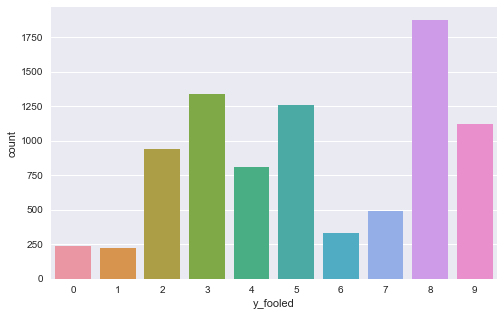

In [25]:
plt.figure(figsize=(8,5))
sns.countplot(x='y_fooled', data=example_results[example_results.y_true != example_results.y_fooled])

In [26]:
wrong_predictions = example_results[example_results.y_true != example_results.y_predicted]
wrong_predictions.shape

(1513, 4)

In [27]:
X_test.shape

(16800, 784)

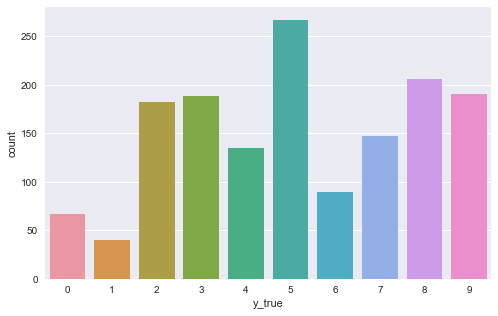

In [28]:
plt.figure(figsize=(8,5))
sns.countplot(x='y_true', data=wrong_predictions)

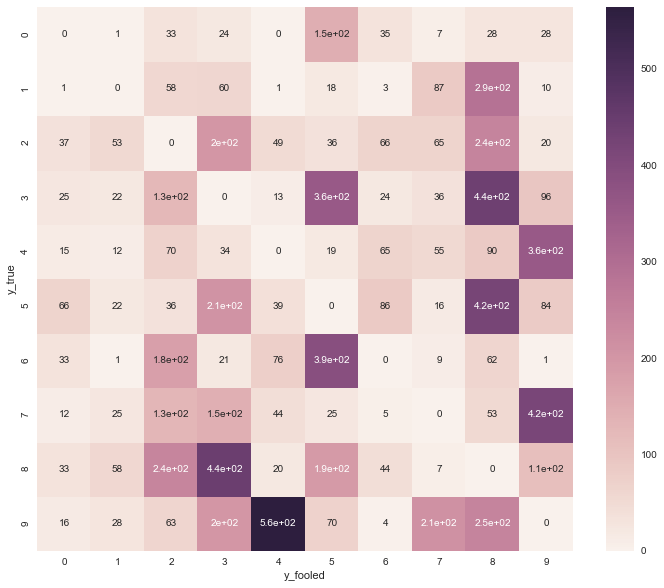

In [29]:
attacktargets = example_results[example_results.y_true != example_results.y_fooled].groupby('y_true').y_fooled.value_counts().unstack()
attacktargets = attacktargets.fillna(0.0)

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(attacktargets, annot=True, ax=ax)